# European Airbnb Listing Price Analysis - a Report

### Prerequisites
Used libraries: `tidyverse`, `tidymodels`, `GGally`, `cowplot`.

## Introduction

<!-- Warned that we could trim this down in proposal, but i don't wanna check worsd lmao-->

Europe is the most traveled region in the world (UNWTO, 2023) and there are many countries to explore. In order to have the most enjoyable trip, proper planning and budgeting is required. Airbnb is one of the most popular ways to find accommodation while you travel. Hence, we would like to determine what factors determine the price of an Airbnb listing in ten most popular European cities, how strongly they affect Airbnb listing prices, and build a model that predicts the price given properties about the listing. By performing multivariable linear regression, we will address these predictive statements: What   categorical and numerical factors or predictors exhibit significant correlation with Airbnb room prices? From this, we will use Airbnb determinants that have significant relationship (consider strength and direction) with pricing to predict the cost of an Airbnb room in Europe. The dataset we will use is from a study published in Tourism Management titled, “Determinants of Airbnb prices in European cities: A spatial econometrics approach” (Gyódi & Nawaro, 2021). These datasets are separated by city and type of day and contains numerical determinants such as ‘person_capacity’, ‘cleanliness_rating’, ‘bedrooms’ and categorical determinants such as ‘room_type’ and other determinants of Airbnb prices. The variable, ‘realSum’, is the total price of Airbnb listing, which will be predicted using linear regression by analyzing its relationships with Airbnb determinants.

## Methods and Results

We download the data from the source, which was split into multiple CSV files, which we recombine back into one data table. We removed the unneeded variables, such as an ID/incrementing number, dummy variables (which we would recreate later), and the unscaled versions of attraction and restaurant indices. We are not using longitude/latitude for analysis as they are unlikely to have an impact that would not be accounted for by the other variables (such as the distance from the city center).

In [1]:
options(tidyverse.quiet = TRUE);
suppressPackageStartupMessages(library(tidyverse));
suppressPackageStartupMessages(library(tidymodels));
suppressPackageStartupMessages(library(GGally));
suppressPackageStartupMessages(library(cowplot));
# Cities are, amsterdam, athens, barcelona, berlin, budapest, lisbon, london, paris, rome, vienna, days are weekdays, weekends
url_first <- "https://zenodo.org/record/4446043/files/"
cities <- c("amsterdam", "athens", "barcelona", "berlin", "budapest", "lisbon", "london", "paris", "rome", "vienna");
total_dataset <- tibble()

# Don't constantly query them if rerunning all cells - download first
download.wrapper <- function(file) {
    dir.create("./data/", showWarnings = FALSE); # don't care if it's present
    file.loc <- paste("./data/",file,sep="")
    if (!file.exists(file.loc)) {
        Sys.sleep(0.5) # don't overload their server
        download.file(paste(url_first, file, sep=""), destfile = file.loc)
    }
    return(read_csv(file.loc))
}

for (i in 1:10) {
    sub_data <- download.wrapper(paste(cities[i], "_weekdays.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekday") |>
        suppressMessages()
    sub_data_end <- download.wrapper(paste(cities[i], "_weekends.csv", sep ="")) |>
        mutate(city = cities[i]) |>
        mutate(day = "weekend") |>
        suppressMessages()

    total_dataset <- bind_rows(total_dataset, sub_data, sub_data_end)
}

In [2]:
set.seed(420);

# clean data
airbnb_clean <- total_dataset |>
    select(-1) |> #some incrementing number
# according to https://zenodo.org/record/4446043#.Y9Y9ENJBwUE these columns are dummies:
    select(-room_private, -room_shared) |>
# apparently these are already scaled to [0,100] - drop the duplicate
    select(-attr_index, -rest_index) |>
    mutate(room_type = as_factor(room_type)) |>
    mutate(city = as_factor(city), day = as_factor(day), multi = as_factor(multi), biz = as_factor(biz)) |>
    rename(dist_from_city_centre = dist,
           cost = realSum,
           attraction_index = attr_index_norm,
           restaurant_index = rest_index_norm)

airbnb_split <- initial_split(airbnb_clean, prop = 0.75, strata = room_type)
airbnb_train <- training(airbnb_split)
airbnb_test <- testing(airbnb_split)

glimpse(airbnb_train)

Rows: 38,779
Columns: 17
$ cost                       <dbl> 2771.3074, 1001.8044, 675.6028, 933.8458, 1…
$ room_type                  <fct> Entire home/apt, Entire home/apt, Entire ho…
$ person_capacity            <dbl> 4, 4, 4, 4, 4, 2, 4, 3, 4, 4, 5, 3, 2, 2, 4…
$ host_is_superhost          <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FA…
$ multi                      <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ biz                        <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ cleanliness_rating         <dbl> 10, 9, 8, 10, 9, 9, 9, 10, 9, 10, 10, 10, 1…
$ guest_satisfaction_overall <dbl> 100, 96, 87, 96, 96, 89, 100, 100, 94, 94, …
$ bedrooms                   <dbl> 3, 2, 1, 2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2…
$ dist_from_city_centre      <dbl> 1.6868070, 3.7191414, 2.9330458, 1.0140664,…
$ metro_dist                 <dbl> 1.4584036, 1.1961124, 0.6280730, 0.3771037,…
$ attraction_index           <dbl> 11.056528, 5.624761, 11.380334, 25.299513, …
$ restaurant_in

We first analyze the distribution of the response variable, cost.

Warning message:
“Removed 188 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_bar()`).”


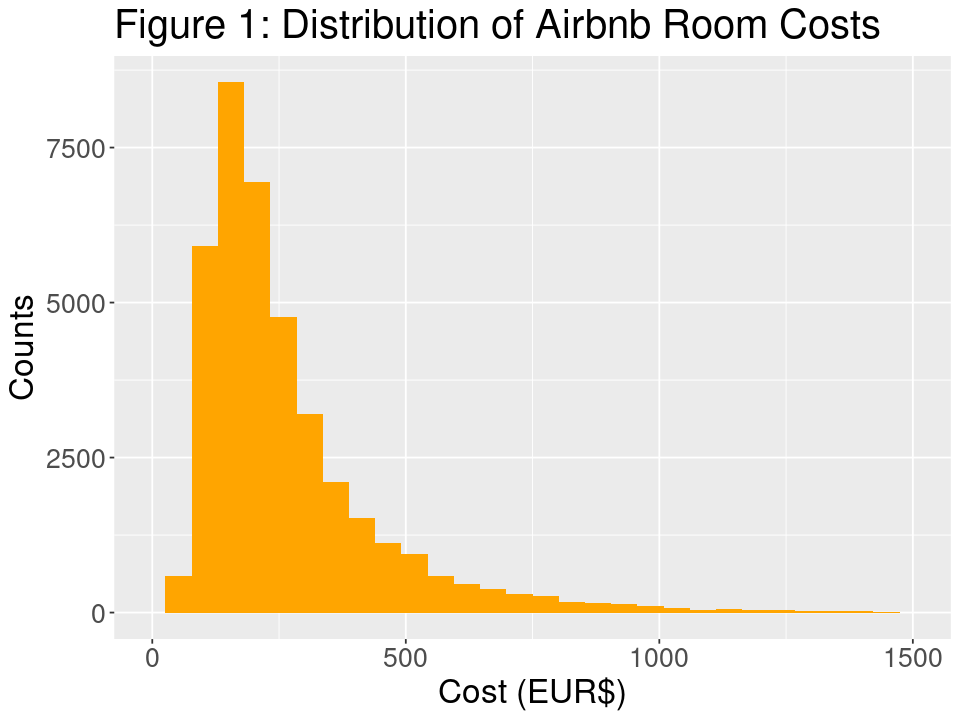

In [3]:
options(repr.plot.width = 8, repr.plot.height = 6)

ggplot(airbnb_train, aes(x=cost)) +
    geom_histogram(fill="orange", bins = 30) +
    xlim(0,1500) +
    labs(x="Cost (EUR$)", y="Counts", title="Figure 1: Distribution of Airbnb Room Costs") +
    theme(text = element_text(size = 20))

We see that the distribution of the cost has a strong right skew, with an average price of about \\$280. This could suggest a tendency to have more relatively expensive properties than there are very cheap ones or there are outliers (i.e. rather unusually expensive homes) present in the data.

Next, we analyze the distribution of the cost in relation to categorical variables, to see what categorical variables will be useful in the analysis.

Warning message:
“attributes are not identical across measure variables; they will be dropped”
Warning message:
“Removed 8322 rows containing non-finite values (`stat_bin()`).”
Warning message:
“Removed 38 rows containing missing values (`geom_path()`).”


Rows: 38,779
Columns: 7
$ cost              <dbl> 2771.3074, 1001.8044, 675.6028, 933.8458, 1032.9717,…
$ biz               <fct> 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ city              <fct> amsterdam, amsterdam, amsterdam, amsterdam, amsterda…
$ day               <fct> weekday, weekday, weekday, weekday, weekday, weekday…
$ host_is_superhost <lgl> TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ multi             <fct> 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0…
$ room_type         <fct> Entire home/apt, Entire home/apt, Entire home/apt, E…


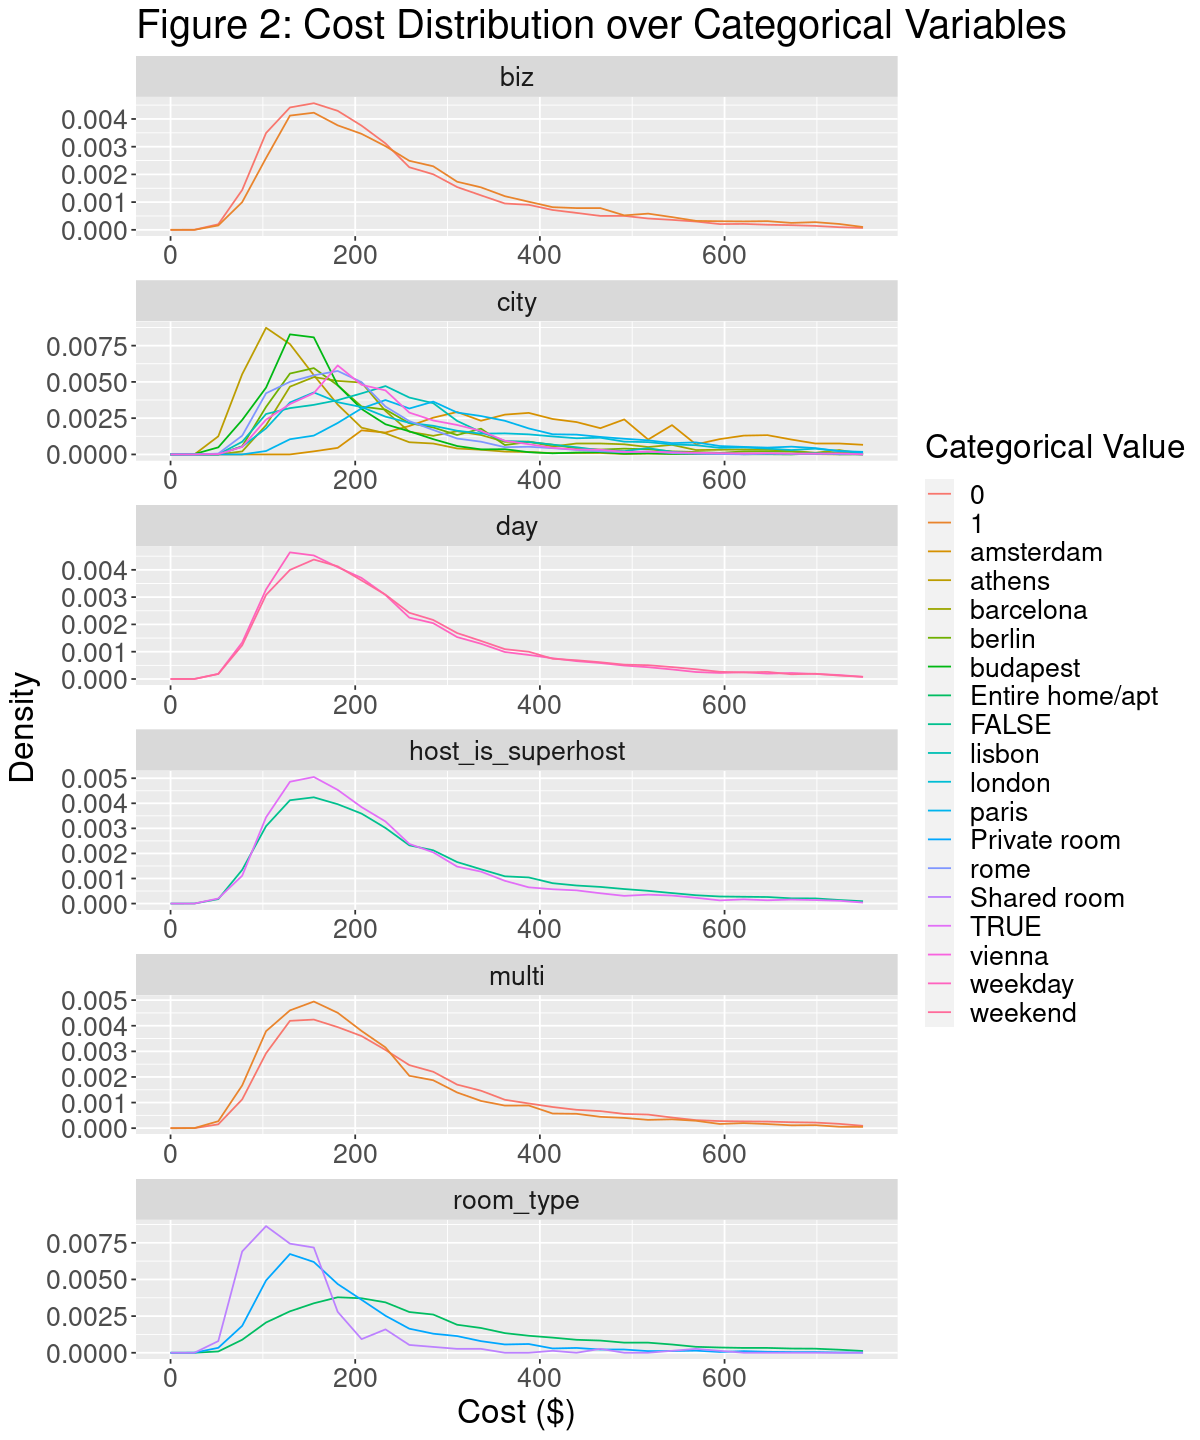

In [4]:
options(repr.plot.width = 10, repr.plot.height = 12)

airbnb_categorical <- airbnb_train |>
    select(cost, biz, city, day, host_is_superhost, multi, room_type)

# https://stackoverflow.com/questions/24648729/plot-one-numeric-variable-against-n-numeric-variables-in-n-plots
# can't use ggpairs since we only want against ONE variable
airbnb_categorical |>
    gather(-cost, key = "variable", value = "value") |>
    ggplot(aes(cost, after_stat(density), color = value)) + 
        geom_freqpoly(bins=30) +
        facet_wrap(~variable, scales = "free", ncol = 1) +
        xlim(0,750) + # want smaller axes
        labs(x = "Cost ($)", y = "Density", color = "Categorical Value", title = "Figure 2: Cost Distribution over Categorical Variables") +
        theme(text = element_text(size = 20))

glimpse(airbnb_categorical);

From this, we can determine a few things. Firstly, whether the host is a superhost, the day of the week the data was taken, whether the host is a 'multi-host' or a business does not affect the price, as they each have the same distribution (just with lower counts). However, we notice that the room type and the city clearly has an impact on the price. Thus, we can filter out all categorical variables except the room type and city.

Further, the distributions are similar to the overall distribution of cost - skewed with a heavy right tail.

Next, we analyze the numerical variables' distributions versus cost. Note that we change the y axis bounds because there are some outlier observations that skew the axis (i.e. listings of around \\$13000)

Warning message:
“Removed 208 rows containing missing values (`geom_point()`).”


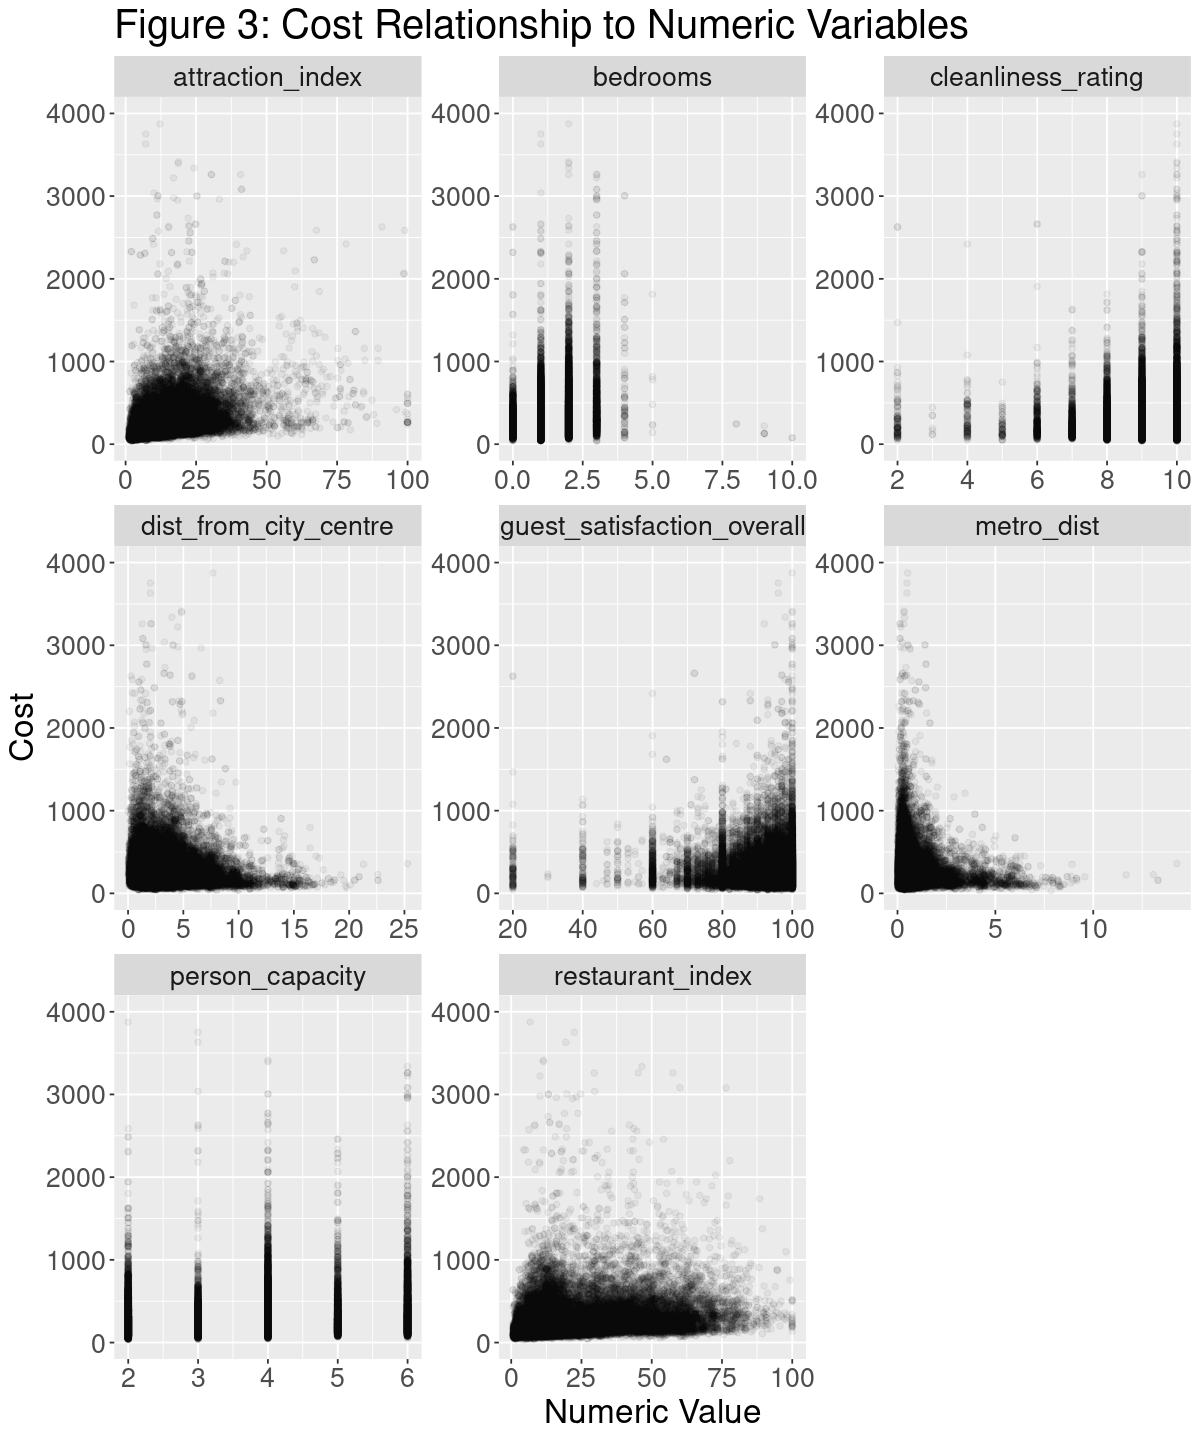

In [5]:
options(repr.plot.width = 10, repr.plot.height = 12)

airbnb_numeric <- airbnb_train |>
    select(cost, person_capacity, cleanliness_rating, guest_satisfaction_overall,
           bedrooms, dist_from_city_centre, metro_dist, attraction_index, restaurant_index)

airbnb_numeric |>
    gather(-cost, key = "variable", value = "value") |>
    ggplot(aes(x=value, y = cost)) + 
        geom_point(alpha = 0.05) +
        facet_wrap(~variable, scales = "free", ncol = 3) +
        ylim(0,4000) + #!!!
        labs(x = "Numeric Value", y = "Cost", title = "Figure 3: Cost Relationship to Numeric Variables") +
        theme(text = element_text(size = 20))

We see that the capacity of an Airbnb listing likely does not have an impact on the price, but a related variable - the number of available bedrooms, has an impact on the price of the listing. 
There is a slight positive linear relationship between cost and the restaurant/attraction index, but has a fair amount of variance. 

We also see a fair amount of potential outliers in the data, i.e. unusually expensive rooms. Under the assumption that they are outliers, the previous linear relationships would likely hold, however the model will need to account for the fact that those values are outliers as ordinary least squares linear regression is not robust to outliers, as the linear models will tend to skew towards the outliers even if the rest of the data follows a perfectly linear pattern. Instead of modifying the model, we  handle this by removing outliers from the data. Noticing that most of our outliers are prices that are unusually high, we can remove outliers by simply defining a cutoff or filtering for prices below a certain range. We will return to selecting the cutoff later.

Next, we check colinearity between predictors by visualizing the numerical predictors in pairs.

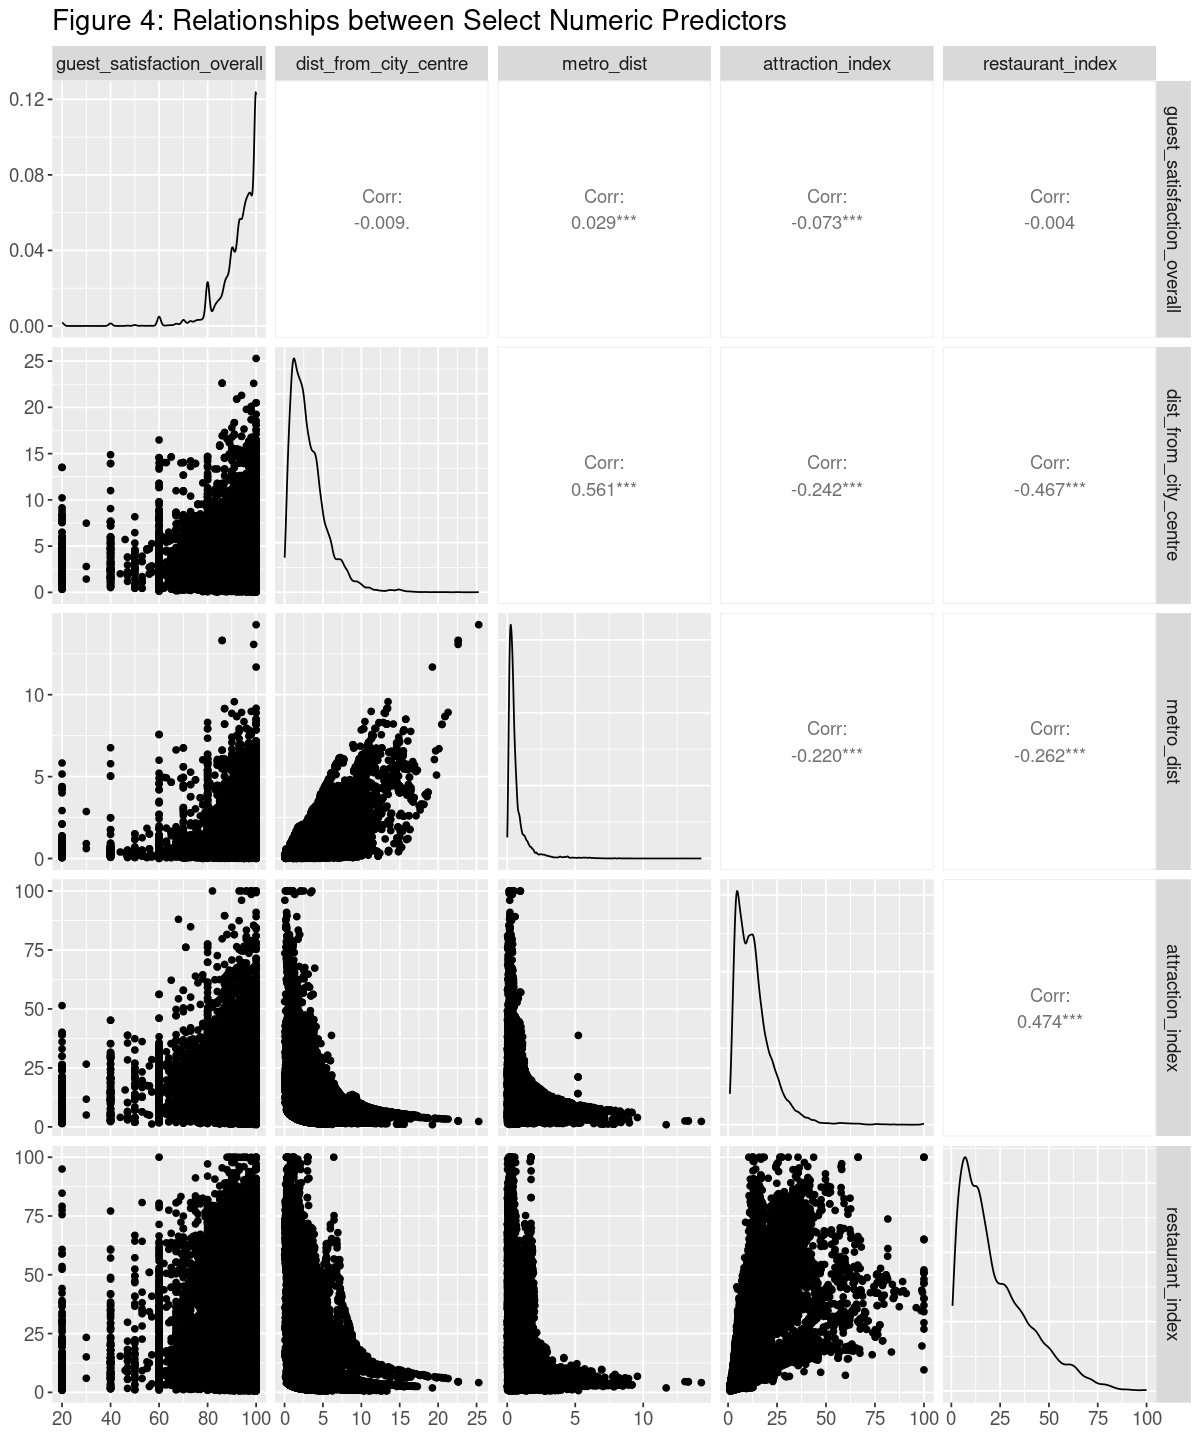

In [6]:
options(repr.plot.width = 10, repr.plot.height = 12)

airbnb_sub_numeric <- airbnb_train |>
    select(guest_satisfaction_overall, dist_from_city_centre, metro_dist, attraction_index, restaurant_index)

ggpairs(airbnb_sub_numeric) +
    labs(title = "Figure 4: Relationships between Select Numeric Predictors") +
    theme(text = element_text(size = 14))

Figure 4 indicates possible relationships between predictors, such as a moderately strong linear relationship between the distance from city center and distance from metro stations, or a possible linear relationship between the restaurant index and attraction index. This is further supported by the high correlation coefficients between most variables. We also notice very strong logarithmic or strictly decreasing polynomial relationships between the attraction and restaurant indices and the distances to the city center or metro stations.

<!-- 
I mean technically colinearity is *terrible* and would use something like ridge/lasso regression with something like glmnet...
and also use L1 loss instead of L2 due to outliers

but I don't think we're allowed to do that LOL
-->
Thus, we fit a linear model that would incorporate these parameters: a one-hot encoded representation of relevant categorical variables - city and room type, a linear relationship between guest satisfaction, distance from city center, restaurant and attraction index, number of bedrooms, cleanliness rating and distance from metro stations. 

Next, we define the recipe and the linear regression model as previously specified, removing the likely irrelevant variables and one-hot encoding the categorical variables. Note due to perfect colinearity between one-hot encoded variables (as you can determine the last variable given the results of the other remaining values) we remove the last value for each categorical variable, so the coefficients for each one-hot encoded categorical variable would be a change in mean relative to the removed category.

In [7]:
lm_spec <- linear_reg(mode = "regression", engine = "lm");

lm_recipe <- recipe(cost ~ ., data = airbnb_train) |>
    step_rm(person_capacity, lat, lng, biz, multi, day, host_is_superhost) |>
    step_dummy(all_nominal_predictors(), one_hot = TRUE) |>
    step_rm(city_vienna, room_type_Shared.room) # they're linear combinations of the other 2

Now, we return to the choice of cutoff for outliers. We split the training set further into a training and validation set and train multiple models each with a different cutoff. The cutoff will remove values from the training dataset that the linear model uses and we measure the linear model's performance using mean absolute error, as it is more robust to outliers compared to root mean squared error.

<!-- if one of you guys wants to figure out cross-validation without it bricking your PC try it-->

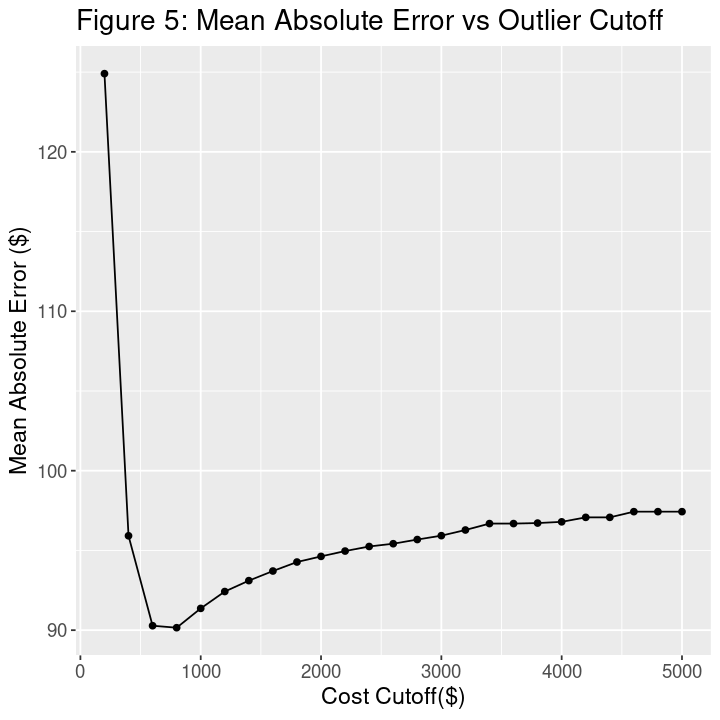

In [8]:
options(repr.plot.width = 6, repr.plot.height = 6)

cutoffs <- tibble(cutoff = seq(200,5000,200));
airbnb_subsplit <- initial_split(airbnb_train, prop = 0.75, strata = room_type)
airbnb_subtrain <- training(airbnb_subsplit)
airbnb_validation <- testing(airbnb_subsplit)

# Return MAE when fitting the training data after filtering from cutoff
fit.to.valid <- function(cut, train, valid) {
    return(workflow() |>
        add_recipe(lm_recipe) |>
        add_model(lm_spec) |>
        fit(train |> filter(cost < cut)) |>
        predict(valid) |>
        bind_cols(valid) |>
        metrics(truth = cost, estimate = .pred) |>
        filter(.metric == "mae") |>
        select(.estimate) |>
        pull())
}

cutoffs |>
    rowwise() |>
    mutate(mae = fit.to.valid(cutoff, airbnb_subtrain, airbnb_validation)) |>
    ggplot(aes(x = cutoff, y = mae)) +
        geom_line() +
        geom_point() +
        labs(x="Cost Cutoff($)", y = "Mean Absolute Error ($)", title="Figure 5: Mean Absolute Error vs Outlier Cutoff") +
        theme(text = element_text(size=14))

We see that the best cutoff is on the lower end, around 600-1000. We pick the best cutoff, which is around 600. 600 seems reasonable, as the median and mean hovers around 220 and 280 respectively, while the 75th percentile is at 320, so a cutoff of 600 would still keep the vast majority of the data while removing rooms that are unusually expensive. Furthermore, we can check a different outlier detection method: the $1.5$ IQR rule, where we consider datapoints greater than the 3rd quartile plus $1.5$ times the interquartile range (distance from the first to the third quartile) or datapoints less than the 1st quartile minus $1.5$ times the interquartile range as an outlier (Khan Academy, 2023). Calculating those values, we find that the outlier cutoff is the range $[-107, 576]$ (since we have no data less than 0, we have no outliers on the low end), which is similar to what we have previously, suggesting the cutoff is appropriate.

In [9]:
airbnb_train_cost <-
    airbnb_train |>
    select(cost) |>
    pull()
upper.range <- quantile(airbnb_train_cost, 0.75, names = FALSE) + 1.5* IQR(airbnb_train_cost)
lower.range <- quantile(airbnb_train_cost, 0.25, names = FALSE) - 1.5 * IQR(airbnb_train_cost)
print(sprintf("Lower Bound: %.2f, Upper Bound: %.2f", upper.range, lower.range))

[1] "Lower Bound: 575.74, Upper Bound: -107.25"


Finally, with a outlier cutoff decided, we refit the model on the full dataset after performing the cutoff, counting the number of entries removed.

In [10]:
airbnb_train |>
    filter(cost >= 600) |>
    nrow()

lm_fit <- workflow() |>
    add_recipe(lm_recipe) |>
    add_model(lm_spec) |>
    fit(airbnb_train |> filter(cost < 600))
lm_fit

[1] 2489

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
3 Recipe Steps

• step_rm()
• step_dummy()
• step_rm()

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
               (Intercept)          cleanliness_rating  
                   -5.7840                      7.9144  
guest_satisfaction_overall                    bedrooms  
                   -0.3016                     43.1300  
     dist_from_city_centre                  metro_dist  
                   -1.8744                     -4.0922  
          attraction_index            restaurant_index  
                    2.7142                      0.6317  
    room_type_Private.room   room_type_Entire.home.apt  
                   37.0936                    142.3755  
            city_amsterda

We also note that the cutoff removed about 5% of the training dataset. Further, most of the coefficients appear statistically significant. We see considerable variation in the coefficients of the cities: we see that Athens is generally \\$101 cheaper than Vienna, while Amsterdam is on average \\$177 more expensive. We also see that private rooms are on average \\$37 more expensive than shared rooms, and entire homes are on average \\$142 more expensive.

Next, we visualize the model. Noting that the categories are one-hot encoded, we can draw each category's values' additive effect as a bar plot to each other effectively holding all else equal.

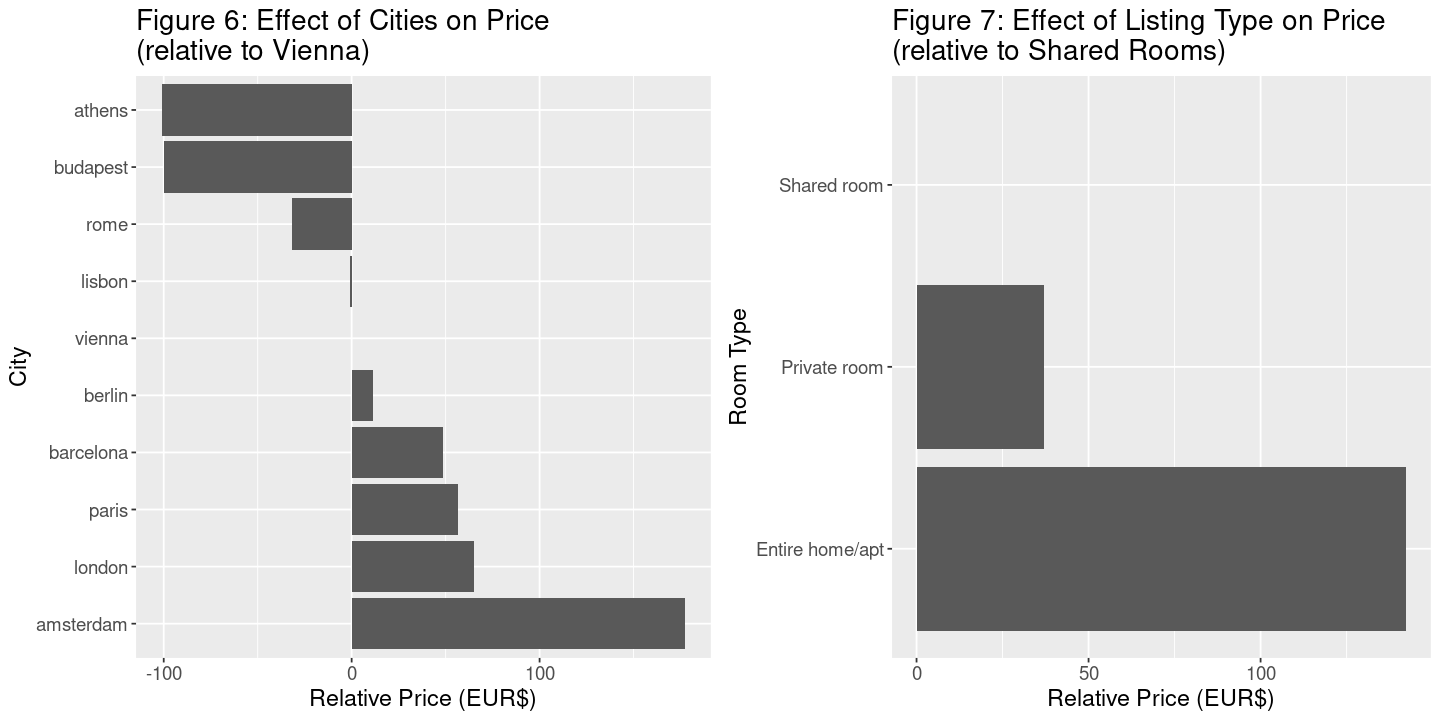

In [11]:
options(repr.plot.width = 12, repr.plot.height = 6)

coefficients <- lm_fit |>
    extract_fit_parsnip() |> # as pull_workflow_fit() is deprecated
    tidy() |>
    mutate(name = term, value = estimate) |>
    select(name, value) |>
    mutate(name = str_replace_all(name, "\\.", " ")) |>
    mutate(name = str_replace_all(name, "home apt", "home/apt"))

city_coef_plot <- coefficients |>
    filter(startsWith(name, "city_")) |>
    mutate(name = substr(name, 6, 99)) |>
    bind_rows(tibble(name = "vienna", value = 0)) |> # relative to removed entry
    ggplot(aes(x=fct_reorder(name, value, .desc = TRUE),y=value)) +
        coord_flip() +
        geom_bar(stat = "identity") +
        theme(text=element_text(size=14)) +
        labs(x= "City", y = "Relative Price (EUR$)", title = "Figure 6: Effect of Cities on Price\n(relative to Vienna)")

room_coef_plot <- coefficients |>
    filter(startsWith(name, "room_type_")) |>
    mutate(name = substr(name, 11, 99)) |>
    bind_rows(tibble(name = "Shared room", value = 0)) |> # relative to removed entry
    ggplot(aes(x=fct_reorder(name, value, .desc = TRUE),y=value)) +
        coord_flip() +
        geom_bar(stat = "identity") +
        theme(text=element_text(size=14)) +
        labs(x= "Room Type", y = "Relative Price (EUR$)", title = "Figure 7: Effect of Listing Type on Price\n(relative to Shared Rooms)")
plot_grid(city_coef_plot, room_coef_plot, ncol = 2)

Next, we draw each variable in relation with respect to price of the listing. The drawn smoothed line will hold all other values equal at their means.

Warning message:
“Removed 188 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 188 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 188 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 188 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 188 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 188 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 188 rows containing missing values (`geom_point()`).”


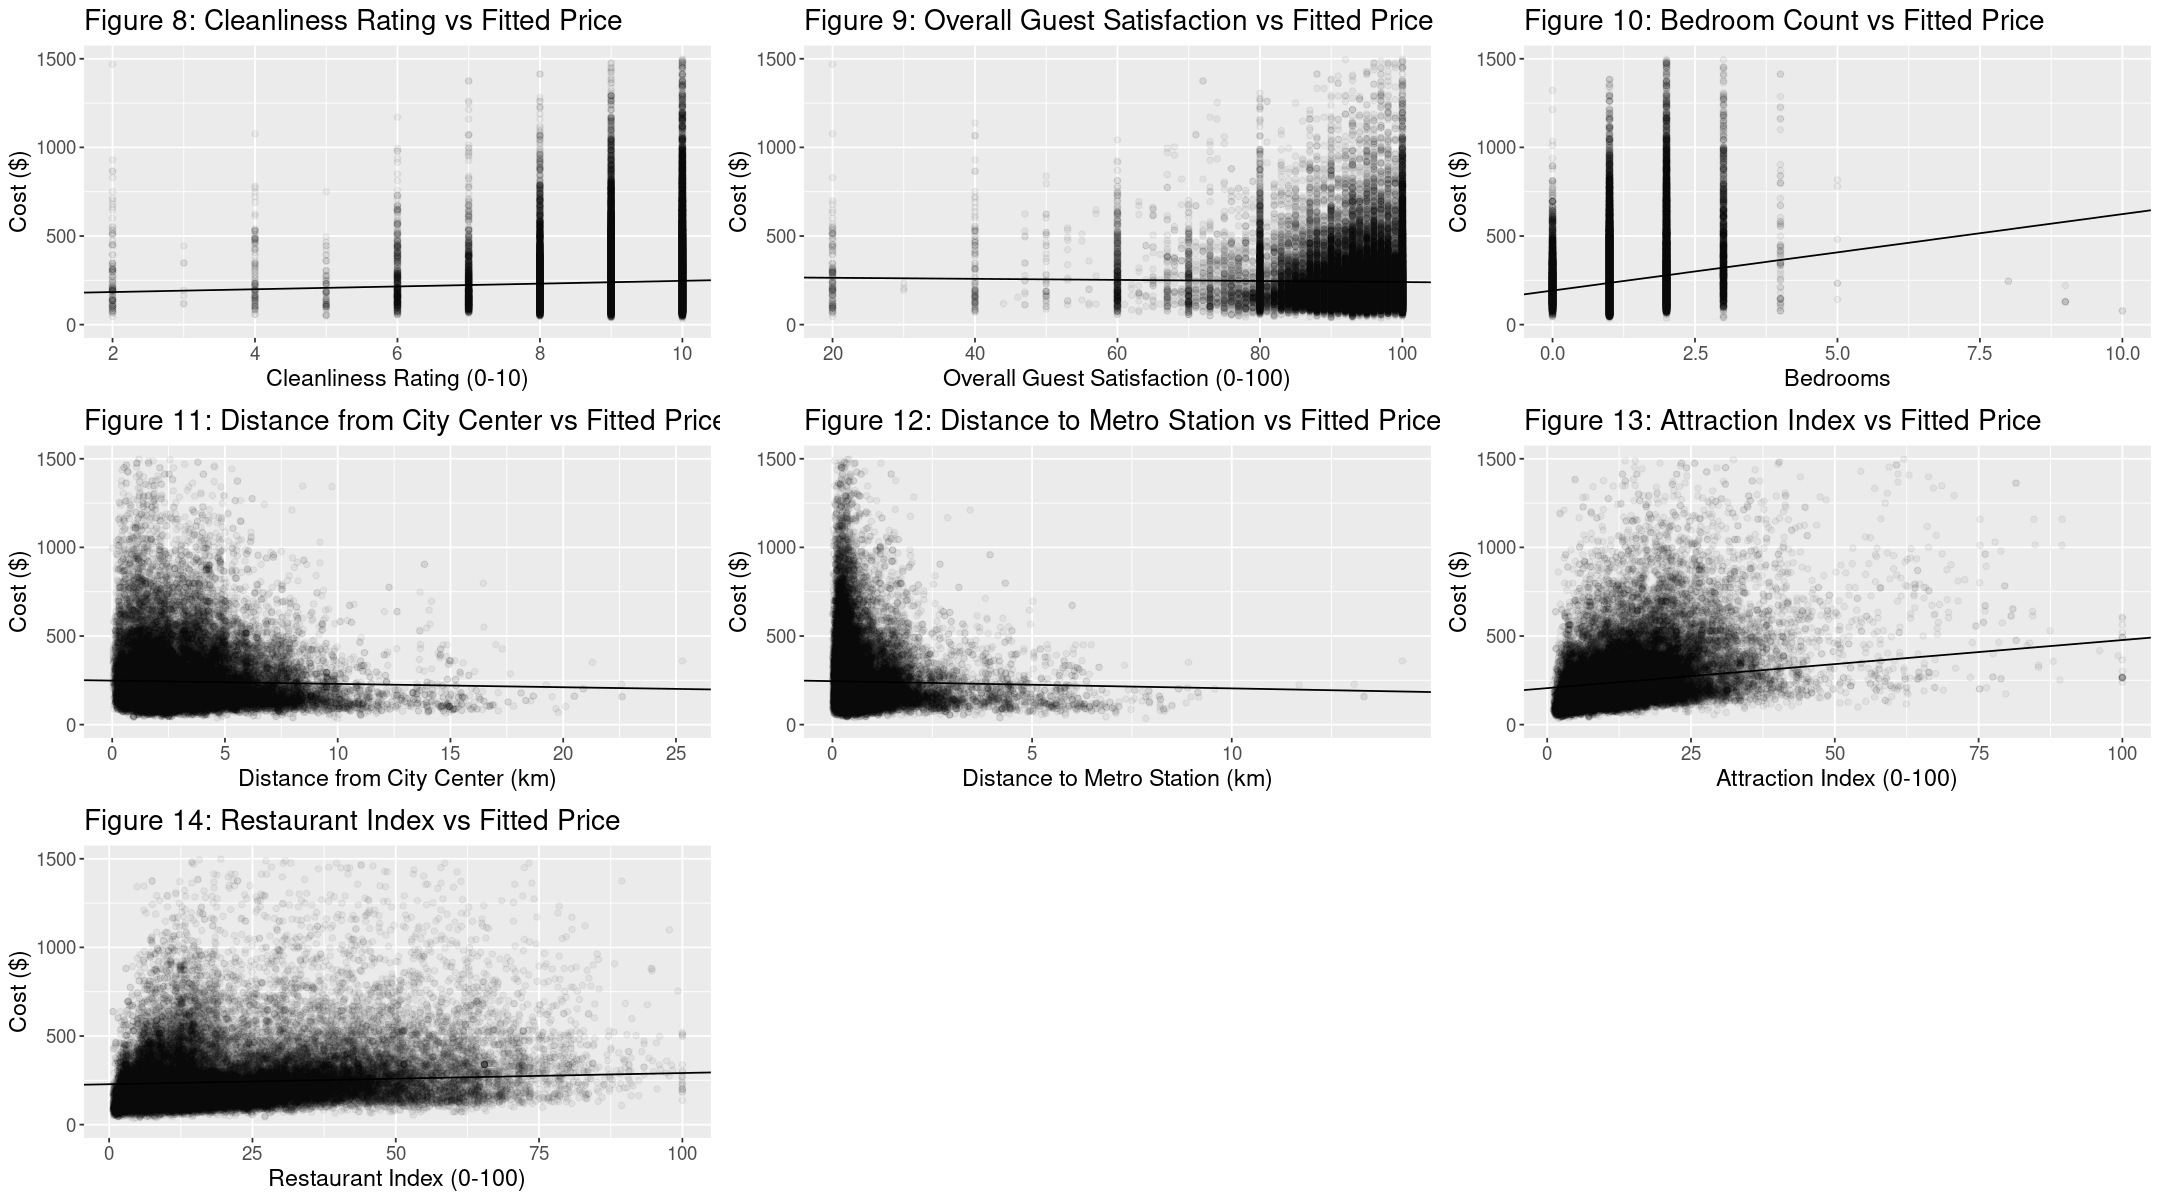

In [12]:
options(repr.plot.width = 18, repr.plot.height = 10)

# Gets 'mean' of the var from the training data
coef.to.mean <- function(catvar) {
    initial.num <- nrow(airbnb_train)
    if (startsWith(catvar, "room_type_")) {
        room.type.name <- substr(catvar,11,99);
        return ((airbnb_train |> filter(room_type == room.type.name) |> nrow())/initial.num);
    }
    if (startsWith(catvar, "city_")) {
        city.name <- substr(catvar,6,99);
        return ((airbnb_train |> filter(city == city.name) |> nrow())/initial.num);
    }
    if (startsWith(catvar, "(Intercept)")) {
        return (1)
    }
    return (airbnb_train |> select(contains(catvar)) |> pull() |> mean());
}

coef.means <- coefficients |>
    rowwise() |>
    mutate(means = coef.to.mean(name) * value)

mean.sum.exclude <- function(indexExcl) {
    return(coef.means |> tibble() |> slice(-indexExcl) |> select(means) |> map_df(sum) |> pull())
}

slope.and.intercept <- coefficients |>
    mutate(index = 1:19) |>
    slice(2:8) |>
    rowwise() |>
    mutate(excl = mean.sum.exclude(index)) |>
    select(-index) |>
    tibble()

labels <- c("Cleanliness Rating (0-10)",
            "Overall Guest Satisfaction (0-100)",
            "Bedrooms",
            "Distance from City Center (km)",
            "Distance to Metro Station (km)",
            "Attraction Index (0-100)",
            "Restaurant Index (0-100)");
titles <- c("Figure 8: Cleanliness Rating vs Fitted Price",
           "Figure 9: Overall Guest Satisfaction vs Fitted Price",
           "Figure 10: Bedroom Count vs Fitted Price",
           "Figure 11: Distance from City Center vs Fitted Price",
           "Figure 12: Distance to Metro Station vs Fitted Price",
           "Figure 13: Attraction Index vs Fitted Price",
           "Figure 14: Restaurant Index vs Fitted Price");

plot.one <- function(index) {
    row <- slope.and.intercept |> slice(index);
    varname <- row |> select(name) |> pull();
    slope <- row |> select (value) |> pull();
    intercept <- row |> select(excl) |> pull();
    return(ggplot(airbnb_numeric, aes(x=get(varname),y=cost)) +
            geom_point(alpha = 0.05) +
                geom_abline(intercept = intercept, slope = slope) +
                ylim(0,1500) +
                labs(x=labels[index], y= "Cost ($)", title = titles[index]) +
                theme(text = element_text(size=14)));
}
plots <- lapply(1:7,plot.one);
plot_grid(plotlist=plots,ncol=3);

Next, we calculate the test error on predicting on the test set that the data has not seen using mean absolute error as it is robust to outliers.

In [13]:
test_error <- lm_fit |>
    predict(airbnb_test) |>
    bind_cols(airbnb_test) |>
    metrics(truth = cost, estimate = .pred) |>
    filter(.metric == "mae") |>
    select(.estimate) |>
    pull()

print(sprintf("Mean Absolute Error: %.2f", test_error))

[1] "Mean Absolute Error: 92.49"


The model seems to predict values with an error of about $93.

## Discussion

There were numerous factors correlated with AirBnB listing prices. Firstly, different cities can have significantly different prices and this was expected, as different cities would have significantly different costs of living and thus different AirBnB listing prices. There is also a negative relationship between distance from city centers and metro stations and cost, where being far away from city centers results in a lower cost. This relationship was expected, but the weakness of the relationship was not expected. One potential consideration is that being far away from a metro station also likely makes a user further away from a city center, which typically has numerous restaurants or attractions in one location. Previous findings on lodging accomodations by Ryan (2022) also supports that downtown and urban areas are in higher demand for rooms and lodging for travellers due to the shorter distance to services and leisure activities. Thus, being far away from a metro station or the city center would influence other variables as well, so the low price difference could be attributed to those effects on other variables. The coefficient for metro stations has significantly higher magnitude than that for city centers, which could suggest that accessibility is a more important determinant of AirBnB prices than proximity to city centers. We also notice that AirBnB listings for the entire home or apartment is the most expensive type of listing followed by private and shared listings. This was expected, as giving the user more space would raise the price of the listing.

We also notice a strong positive relationship between the amount of attractions and price, and a weaker positive relationship between the amount of restaurants and price. This was expected as the presence of attractions and restaurants increases the price, but the weakness of the effect on price was unexpected: an increase in the index by 20 results in an increase in price by \\$54 and \\$12. We expected the price increase to be higher, but may be due to the same reasons listed previously for the distance to metro stations and city centers. Guest satisfaction has a slight negative relationship between guest satisfaction and price, where the highest satisfaction would result in a \\$30 lower price in the model versus the lowest. This was unexpected, as we anticipated a positive relationship since a better listing would warrant a higher price. One possible explanation is that guests are more satisfied paying less for an AirBnB, which would explain the negative relationship. There is a strong positive correlation between the cleanliness rating and the price, which was expected as guests would likely prefer clean rooms. There is also a very strong positive correlation between the number of bedrooms and the price (where each bedroom is about \\$43) which was also expected as more bedrooms would give the guests more space and thus would warrant a higher price. However, we also noticed relationships (linear and non-linear) between various predictors, such as a possible linear relationship between the distance from metro stations and the distance from city centers. This may result in the coefficients being less interpretable or under/overestimating the impact of certain relationships on cost.

We note information about the day (weekend versus weekday) of the stay and data about the host such as whether they are a 'superhost', have multiple properties or a business is likely not related to price as they have similar distributions. The day of the week was expected to have a relationship with price, but the price distributions looked almost exactly identical. We did not expect a relationship between price and information about the host as guests are more likely to prioritize a good listing than they are to specifically pick a host that is a 'superhost' or a host that has multiple listings. The distributions of price with respect to those variables looked identical, so it was excluded from the model as per the principle of parsimony.

### Impact and Future Considerations

These findings have numerous impacts on both looking for a listing and creating listings. Firstly, guests would expect a higher price for being in locations more ideal for travel, such as those with more space and having close proximity to metro areas. Secondly, the factors such as for what days the listings are selected seem irrelevant to the price of the listing, so travellers would likely not have to worry as to which days the listings are selected for short trips. For AirBnB hosts, they should consider the location of their listing in pricing as their guests are more willing to pay higher prices for being in close proximity to metro areas and city centers.

There are numerous limitations to this analysis that can be answered with further exploration and data. The data was sourced via webscraping looking for a listing that supports 2 people for 2 nights. However, there may be relationships between the number of people and the number of nights and the price, such as a possible lower price per night if the user is looking for a longer stay or if there more people. Further, the data makes no distinction between reasonable and unreasonable prices of listings - a host could potentially set a listing price to be three times the market rate, and the data set would make no indication of that happening (except by appearing to be an outlier). The interactions between variables was not thoroughly investigated in this analysis - we noted possible collinearity between numerical predictors, but there could be other relationships that may not be seen on scatterplots of two variables. For instance, it could be that the categorical variables that have the same distribution actually have impacts when combined with other variables whose relationship was not seen, but the linear regression model would not account for relationships between multiple variables. Furthermore, the coefficients of the linear model may be impacted significantly by the possible colinearity, but that was not investigated thoroughly. In the future, another analysis that applies a penalty on the number of non-zero coefficients used (to favor sparser models) or takes into account other predictor relationships may be useful, including non-linear relationships.

## References

Khan Academy. (2023). Identifying outliers with the 1.5Xiqr rule. Khan Academy. Retrieved April 13, 2023, from https://www.khanacademy.org/math/statistics-probability/summarizing-quantitative-data/box-whisker-plots/a/identifying-outliers-iqr-rule 

Gyódi, K. & Nawaro, L. (2021). Determinants of Airbnb prices in European cities: A spatial econometrics approach, Zenodo 
    https://doi.org/10.1016/j.tourman.2021.104319
    
Ryan, B. (2022). Lodging. Community Economic Development. Retrieved April 11, 2023, from   
    https://economicdevelopment.extension.wisc.edu/articles/evaluating-lodging-opportunities/ 

UNWTO (2023). Number of international tourist arrivals worldwide from 2005 to 
    2022, by region (in millions). In Statista. 
    https://www.statista.com/statistics/186743/international-tourist-arrivals-worldwide-by-region-since-2010/

